<a id='1'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">1. Introduction  </p>

In this notebook we will use CNN (Convolutional Neural Network) for classification. Our purpose to separate normal and pneumonia lung pictures. Dataset already has been splitted as train and test. We will just read them from file. After we will apply data augmentation because our train dataset has just seventy four picture and it's not enough in my opinion. We will create our cnn model for this we will use vgg16 weights on imagenet so our training more success and not take a long time. The last step is to evaluate the model, so we will make a decision as to whether the model is successful or not.

From: https://github.com/JordanMicahBennett/SMART-CT-SCAN_BASED-COVID19_VIRUS_DETECTOR/

**Background**
The 2019 novel coronavirus (COVID-19) presents several unique features. While the diagnosis is confirmed using polymerase chain reaction (PCR), infected patients with pneumonia may present on chest X-ray and computed tomography (CT) images with a pattern that is only moderately characteristic for the human eye Ng, 2020. COVID-19’s rate of transmission depends on our capacity to reliably identify infected patients with a low rate of false negatives. In addition, a low rate of false positives is required to avoid further increasing the burden on the healthcare system by unnecessarily exposing patients to quarantine if that is not required. Along with proper infection control, it is evident that timely detection of the disease would enable the implementation of all the supportive care required by patients affected by COVID-19.

In late January, a Chinese team published a paper detailing the clinical and paraclinical features of COVID-19. They reported that patients present abnormalities in chest CT images with most having bilateral involvement Huang 2020. Bilateral multiple lobular and subsegmental areas of consolidation constitute the typical findings in chest CT images of intensive care unit (ICU) patients on admission Huang 2020. In comparison, non-ICU patients show bilateral ground-glass opacity and subsegmental areas of consolidation in their chest CT images Huang 2020. In these patients, later chest CT images display bilateral ground-glass opacity with resolved consolidation Huang 2020.

COVID is possibly better diagnosed using radiological imaging Fang, 2020 and Ai 2020.

**Content:**
   * [1. Introduction](#1)
   * [2. Imports](#2)
       * [2.1 Load Data From The Kaggle](#2.1)
   * [3. Preprocessing](#3)
   * [4. Visualization](#4)
   * [5.Split Train Dataset For Validation Dataset](#5)
   * [6. Data Augmentetion](#6)
   * [7. Model](#7)
   * [8. Model Evaluate](#8) 

<a id='2'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">2. Imports  </p>

In [13]:
import cv2
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sbn 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.utils import to_categorical
from keras.layers import Dense,Dropout,Conv2D, MaxPooling2D
from keras.layers import BatchNormalization,Flatten,AveragePooling2D

<a id='2.1'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:125%; text-align:center; border-radius: 15px 50px;">2.1 Load Data From The Kaggle  </p>

In [1]:
# define your working directory
import os 
os.chdir("D:/GitHub")

In [2]:
# Connect to Kaggle with API
# Download json file from your kaggle account 
# Go to directory — “C:\Users\<username>\.kaggle\” — and paste here downloaded JSON file
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi() 
api.authenticate() 

In [3]:
# Download dataset from kaggle
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets


  0%|          | 0.00/84.3M [00:00<?, ?B/s]
  1%|1         | 1.00M/84.3M [00:00<00:36, 2.36MB/s]
  2%|2         | 2.00M/84.3M [00:00<00:20, 4.19MB/s]
  4%|3         | 3.00M/84.3M [00:00<00:17, 4.95MB/s]
  6%|5         | 5.00M/84.3M [00:01<00:16, 4.96MB/s]
  8%|8         | 7.00M/84.3M [00:01<00:10, 7.37MB/s]
  9%|9         | 8.00M/84.3M [00:01<00:12, 6.40MB/s]
 11%|#         | 9.00M/84.3M [00:01<00:12, 6.32MB/s]
 12%|#1        | 10.0M/84.3M [00:01<00:11, 6.91MB/s]
 13%|#3        | 11.0M/84.3M [00:01<00:10, 7.59MB/s]
 14%|#4        | 12.0M/84.3M [00:01<00:09, 8.02MB/s]
 15%|#5        | 13.0M/84.3M [00:02<00:08, 8.37MB/s]
 17%|#6        | 14.0M/84.3M [00:02<00:08, 8.65MB/s]
 18%|#7        | 15.0M/84.3M [00:02<00:10, 6.68MB/s]
 21%|##1       | 18.0M/84.3M [00:02<00:07, 9.65MB/s]
 23%|##2       | 19.0M/84.3M [00:02<00:07, 9.61MB/s]
 24%|##3       | 20.0M/84.3M [00:03<00:08, 7.75MB/s]
 25%|##4       | 21.0M/84.3M [00:03<00:08, 8.02MB/s]
 27%|##7       | 23.0M/84.3M [00:03<00:06, 9.56MB/s]
 

In [5]:
# Extract the zip file to the folder under the data folder
from zipfile import ZipFile
zf = ZipFile('covid19-xray-dataset-train-test-sets.zip')
zf.extractall("data/")
zf.close()

In [7]:
path = "D:/GitHub/data/xray_dataset_covid19/"

<a id='3'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">3. Preprocessing  </p>

This section we will prepare the datasets for training. Firstly we will read to dataset from file. Dataset already 
had splitted as train and test. We just need to here define file path. After we will use these file to give function. This function will read files and it's take pictures with to label. Then we just convert features list to array.

In [8]:
# Define File Paths 
train_path = path+"train"
test_path =  path+"test"

train_normal_path = train_path+"/NORMAL"
train_pneumonia_path = train_path+"/PNEUMONIA"

test_normal_path = test_path+"/NORMAL"
test_pneumonia_path = test_path+"/PNEUMONIA"

* Next step we define a function and with this function can able to create train and test data. 

In [9]:
def take_your_data(normal,pneumonia):
    """
    Give data path
    Normal: 0 
    Pneumonia: 1
    This function will return feature and labels.
    Features our images 
    Labels pictures class(like Normal,PNEUMONIA)
    """
    features = []
    labels = []
    for i in tqdm(os.listdir(normal)): #to get pictures from  under normal file
        img_read = cv2.imread(os.path.join(normal,i),3)
        img = cv2.resize(img_read,(224,224)) #size 224x224 sized. 
        features.append(np.array(img)) #convert to array and then add to list
        if normal.split('/')[-1] == 'NORMAL': #we add 0 to label for normal

            labels.append(0)
        else:
            labels.append(1)
            
    for i in tqdm(os.listdir(pneumonia)):
        img_read = cv2.imread(os.path.join(pneumonia,i),3)
        img = cv2.resize(img_read,(224,224)) #size 224x224 sized. 
        features.append(np.array(img)) # convert to array and then add to list
        if pneumonia.split('/')[-1] == 'NORMAL':
            labels.append(0)
        else:
            labels.append(1)  #we add 1 to label for PNEUMONIA
    return features,labels

In [12]:
train_features,train_labels = take_your_data(train_normal_path,train_pneumonia_path)
test_features,test_labels = take_your_data(test_normal_path,test_pneumonia_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.23it/s]


* Next step define train and test dataset 

In [5]:
#Train 
X = np.array(train_features)
y = np.array(train_labels)
y = to_categorical(y) # For classification

In [6]:
# Test 
x_test = np.array(test_features)
y_test = np.array(test_labels)

print("X Test Shape",x_test.shape)
print("Y Test Shape",y_test.shape)

X Test Shape (40, 224, 224, 3)
Y Test Shape (40,)


<a id='4'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">4. Visualization  </p>

This section we will show images from train dataset. We just show twelve picture and we will show separately with
as normal and pneumonia. For this we will define function. This function will takes normal or pneumonia pictures and add them  list. For visualization we will select randomly twelve picture in this list. After we will show on the graph them.

* Next step we will define a function. This function will return train dataset and test dataset pictures.

In [7]:
def data_for_visualization(normal):
    """
    input is data path
    """
    features = []
    for i in tqdm(os.listdir(normal)):
        img_read = cv2.imread(os.path.join(normal,i),3)
        img = cv2.resize(img_read,(224,224))
        features.append(np.array(img))
    return features

In [8]:
train_data_vis_normal = data_for_visualization(train_normal_path)
train_data_vis_pneumonia = data_for_visualization(train_pneumonia_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 26.06it/s]


* Next step is our visualization func define. This function will return randomly pictures. In here we can give dataset name and normal or pneumonia choose.

In [9]:
def visualization(data,name):
    """
    inputs 
    data = Pictures to visualize
    name = Normal , PNEUMONIA
    """
    random_numbers = np.random.randint(0,74,12)
    data_new = [data[i] for i in random_numbers]
    num_cols = 3
    num_rows = 4
    fig,axes = plt.subplots(nrows =num_rows,ncols = num_cols,figsize = (20,20))
    st = fig.suptitle(f"{name} Lungs Images", fontsize=20,y=1)
    for index,img in enumerate(data_new):
        i,j = (index // num_cols, index % num_cols)
        axes[i,j].imshow(X = img)   
        axes[i,j].set_xlabel(name.lower(),fontsize = 16)
    fig.subplots_adjust(top=0.55,wspace=10,hspace=10)
    plt.tight_layout()
    return plt.show()

* Next step will show us normal pictures from train dataset.

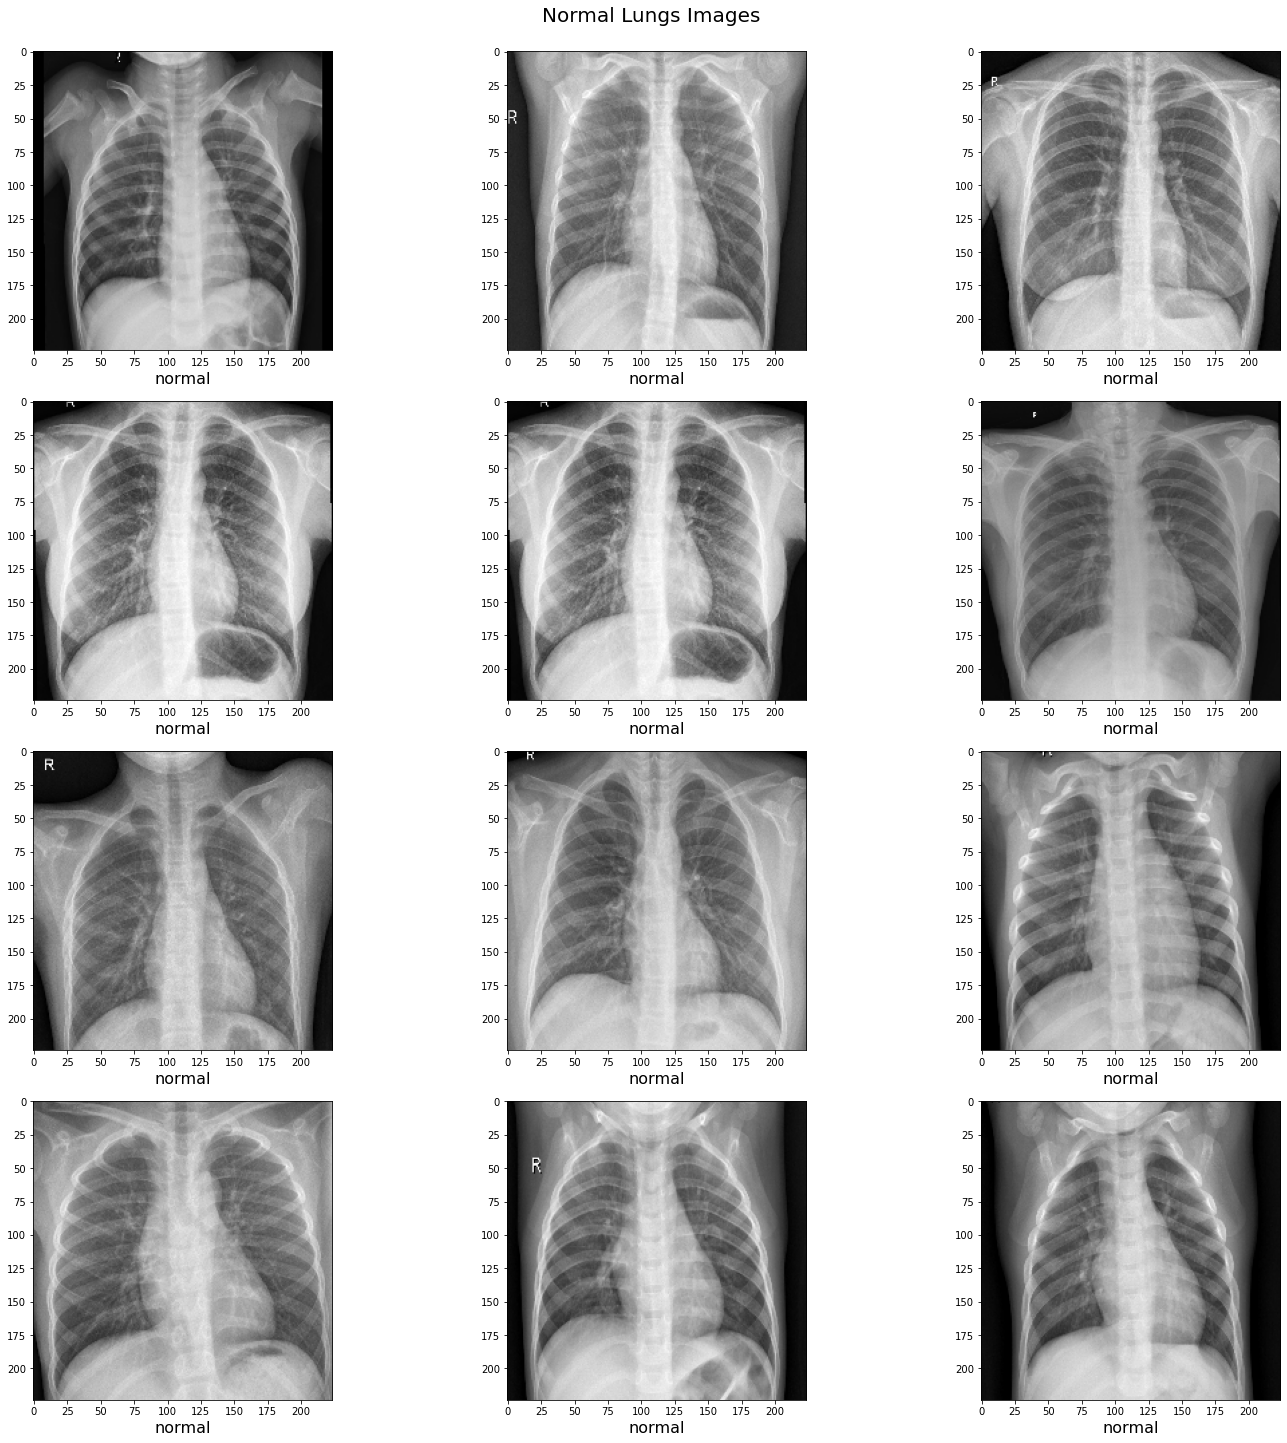

In [10]:
visualization(train_data_vis_normal,"Normal")

* Next step will show us pneumonia pictures from train dataset.

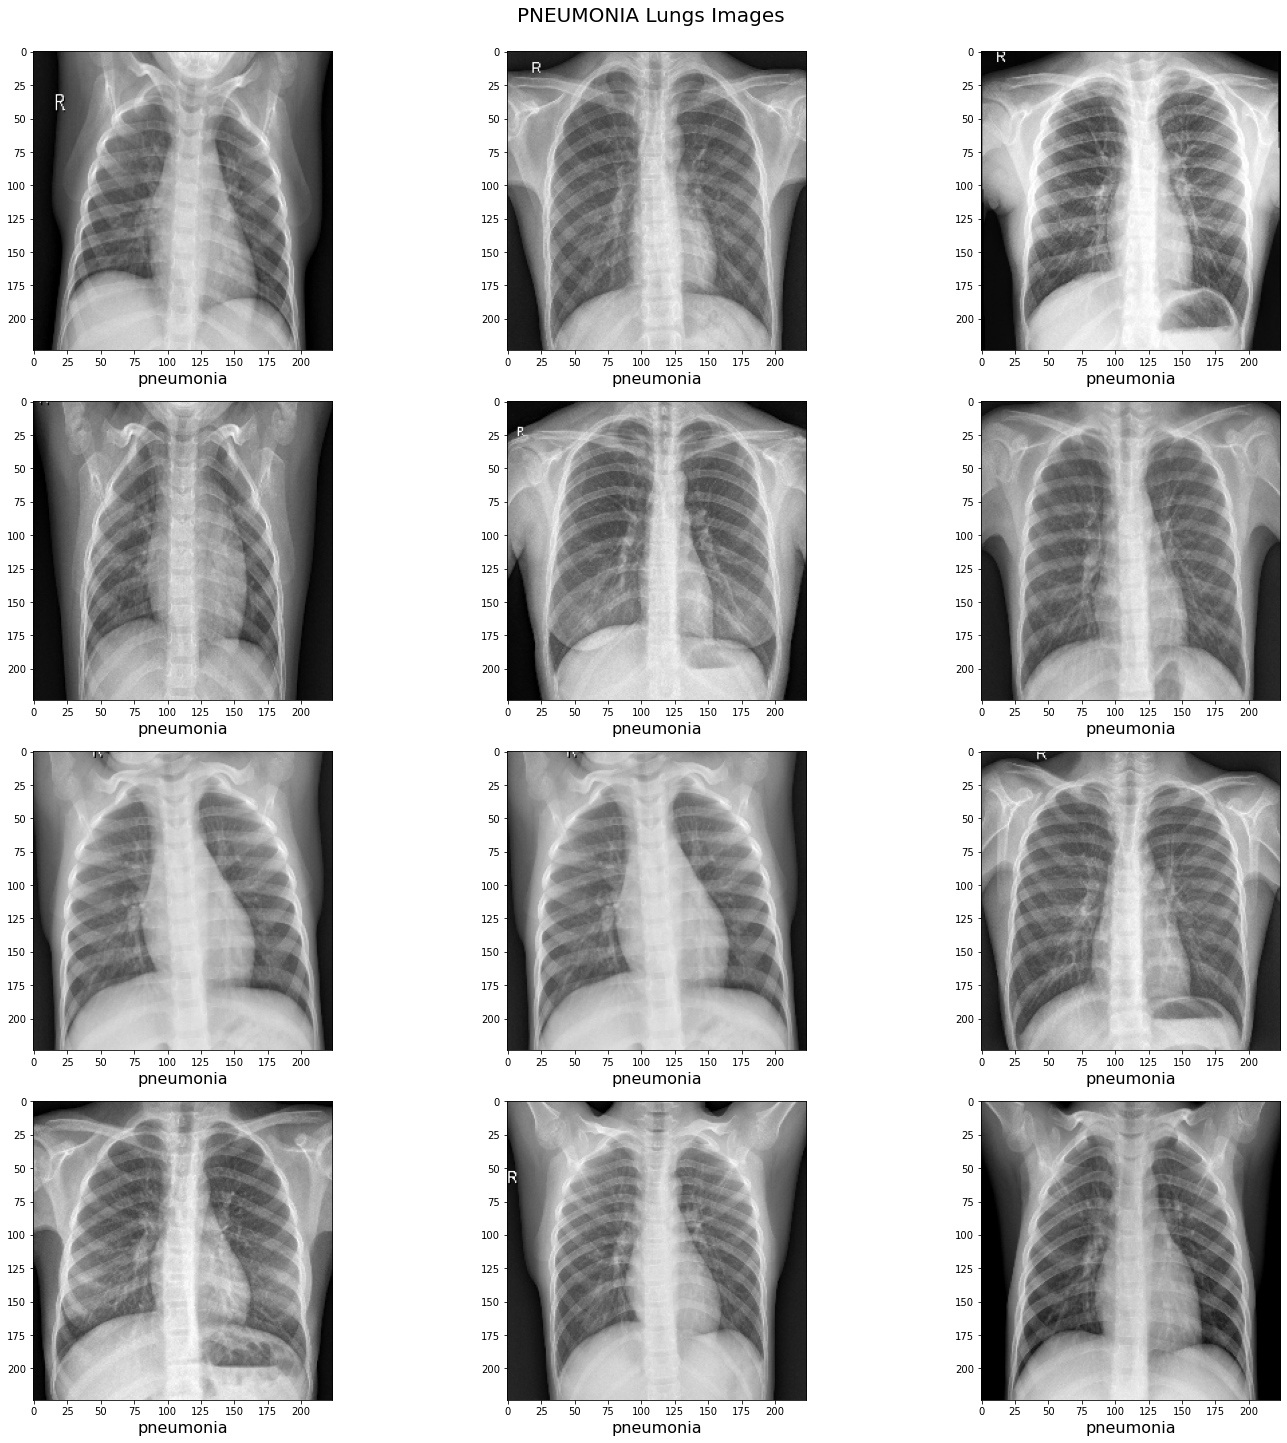

In [11]:
visualization(train_data_vis_normal,"PNEUMONIA")

<a id='5'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">5. Split Train Dataset For Validation Dataset</p>




This section we will split train dataset for validation. Thus we can to observe validation data accuracy when model training. 

In [12]:
# Splity train data 
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size = 0.20,random_state  = 42)

In [13]:
print("X Train Shape",x_train.shape)
print("Y Train Shape",y_train.shape)

print("X Validation Shape",x_val.shape)
print("Y Validation Shape",y_val.shape)

X Train Shape (118, 224, 224, 3)
Y Train Shape (118, 2)
X Validation Shape (30, 224, 224, 3)
Y Validation Shape (30, 2)


<a id='6'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">6. Data Augmentetion</p>

In this section, we will use data augmentetion because our dataset does not have enough data. For this we will use ImageDataGenerator.

In [14]:
train_data_gen = ImageDataGenerator(rotation_range=30,
                                zoom_range=[0.9,1.1],
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)

val_data = val_data_gen.flow(x_val,y_val)

# If you want to show some of augmentation picture try this code.
# aug = train_data_gen.flow(x_train,y_train,save_to_dir = train_path)
# aug.next()

<a id='7'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">7. Model</p>

This section we will create convolutional neural network(CNN) model. For this we will use VGG16 model weights on imagenet. Thus our model it's not be complicated.

In [15]:
## Model params 
epoch_no = 15
batch = 8
dimensions = (224,224,3)

In [16]:
vgg_model = VGG16(weights = 'imagenet',include_top = False,input_shape = dimensions)

x = vgg_model.output

x = MaxPooling2D(pool_size = (2,2))(x)

x = Flatten()(x)

x = Dense(128,activation = 'relu')(x)

x = Dropout(0.4)(x)

x = Dense(2,activation = 'softmax')(x)

model = Model(inputs = vgg_model.input , outputs = x) # combine input and output 

# For the retraining of the VGG16 model
for layer in vgg_model.layers:
    layer.trainable = False
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [17]:
# we use for loss function categorical_crossentropy because we had changed the label column to categorical variable.
model.compile(loss = "categorical_crossentropy",metrics = ["accuracy"],optimizer = "Adam")

In [18]:
# Now we can start to training now we just set training dataset and validation dataset.
# Also we need to decision batch_size and epochs numbers
hist  = model.fit_generator(train_data_gen.flow(x_train,y_train,batch_size = batch),
                  validation_data =val_data,
                  epochs = epoch_no,verbose = 1,steps_per_epoch=len(x_train)//batch,
                  validation_steps=len(x_val)//batch)

Epoch 1/15
14/14 [==============================] - 11s 820ms/step - loss: 1.2505 - accuracy: 0.5545 - val_loss: 0.4452 - val_accuracy: 0.7000
Epoch 2/15
14/14 [==============================] - 4s 299ms/step - loss: 0.5841 - accuracy: 0.7091 - val_loss: 0.1801 - val_accuracy: 0.9333
Epoch 3/15
14/14 [==============================] - 4s 301ms/step - loss: 0.3987 - accuracy: 0.8661 - val_loss: 0.1896 - val_accuracy: 1.0000
Epoch 4/15
14/14 [==============================] - 4s 299ms/step - loss: 0.3736 - accuracy: 0.8364 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 5/15
14/14 [==============================] - 4s 299ms/step - loss: 0.2336 - accuracy: 0.9074 - val_loss: 0.2445 - val_accuracy: 0.9000
Epoch 6/15
14/14 [==============================] - 4s 299ms/step - loss: 0.2629 - accuracy: 0.9091 - val_loss: 0.1397 - val_accuracy: 0.9333
Epoch 7/15
14/14 [==============================] - 4s 301ms/step - loss: 0.1838 - accuracy: 0.9375 - val_loss: 0.0861 - val_accuracy: 0.9667
Epoch

In [19]:
# model.save("train_path/best_model.h5")

<a id='8'></a>
 # <p style="background-color:skyblue; font-family:newtimeroman; font-size:150%; text-align:center; border-radius: 15px 50px;">8. Model Evaluate </p>

This section we evaluate our model. Firstly we will look model loss and model accuracy on graph. After we will look accuracy score, confusion matrix and classification report.

In [20]:
# # For load the model from where we saved before 
# from keras.models import load_model
# model = load_model("C:/Users/Barış/Desktop/BTKAKADEMİ EĞİTİM/Kaggle & Github/X_Ray_Covid_19_CNN/save_models/best_model.h5")

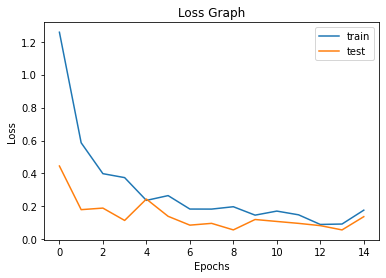

In [21]:
# To show the losses, validation losses of the model in the graph
%matplotlib inline
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Graph")
plt.legend(["train","test"])
plt.show()

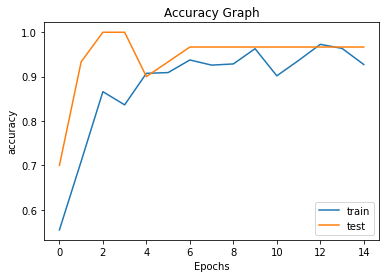

In [22]:
# To show the accuracy, validation accuracy of the model in the graph
%matplotlib inline
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("Accuracy Graph")
plt.legend(["train","test"])
plt.show()

In [23]:
# Let's give the test set that we separate before, to the model  for predict it.
y_hat = model.predict(x_test)
y_pred = np.argmax(y_hat, axis=1)

In [24]:
#Accuracy Score
print("Accuracy Score",accuracy_score(y_test,y_pred))

Accuracy Score 0.975


<AxesSubplot:>

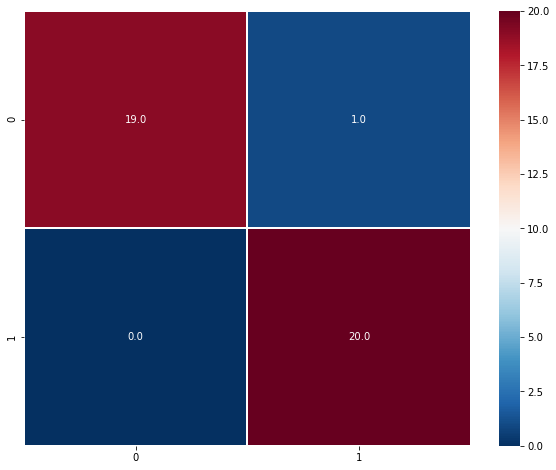

In [25]:
# Confusion matrix 
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sbn.heatmap(cm,annot = True,fmt = '.1f',cmap = 'RdBu_r',linewidth = "1")

In [26]:
# CLassification Report about our prediction
print("Classification Report:\n",classification_report(y_pred,y_test))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

